### HW3 - Question 1

##### Part 1 - 1

In [1]:
!pip install jovian --upgrade --quiet

import jovian


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [3]:
from google.colab import files

uploaded = files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [4]:
! kaggle datasets download franciscoescobar/satellite-images-of-water-bodies/

100% 246M/247M [00:12<00:00, 23.6MB/s]
100% 247M/247M [00:12<00:00, 21.0MB/s]


In [5]:
# Put on the same directory
from zipfile import ZipFile

# specifying the name of the zip file
file = "satellite-images-of-water-bodies.zip"

# open the zip file in read mode
with ZipFile(file, 'r') as zip1:
    # list all the contents of the zip file
    zip1.printdir()

    # extract all files
    print('extraction...')
    zip1.extractall()
    print('Done!')

Streaming output truncated to the last 5000 lines.
Water Bodies Dataset/Images/water_body_1810.jpg 2020-05-18 01:02:52         2496
Water Bodies Dataset/Images/water_body_1811.jpg 2020-05-18 01:02:52         6470
Water Bodies Dataset/Images/water_body_1812.jpg 2020-05-18 01:02:52       332207
Water Bodies Dataset/Images/water_body_1813.jpg 2020-05-18 01:02:52         8613
Water Bodies Dataset/Images/water_body_1814.jpg 2020-05-18 01:02:52         5665
Water Bodies Dataset/Images/water_body_1815.jpg 2020-05-18 01:02:52         2213
Water Bodies Dataset/Images/water_body_1816.jpg 2020-05-18 01:02:52        37916
Water Bodies Dataset/Images/water_body_1817.jpg 2020-05-18 01:02:52         4316
Water Bodies Dataset/Images/water_body_1818.jpg 2020-05-18 01:02:52        18662
Water Bodies Dataset/Images/water_body_1819.jpg 2020-05-18 01:02:52         3211
Water Bodies Dataset/Images/water_body_182.jpg 2020-05-18 01:02:52         1795
Water Bodies Dataset/Images/water_body_1820.jpg 2020-05-18 

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [7]:
def read_images_and_masks(folder_path, image_size, threshold=0.9):
    images = []
    masks = []

    images_folder = os.path.join(folder_path, 'Images')
    masks_folder = os.path.join(folder_path, 'Masks')

    for filename in os.listdir(images_folder):
        if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.jpeg'):
            # Read the mask
            mask = cv2.imread(os.path.join(masks_folder, filename))
            mask_gray = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
            mask_gray[mask_gray>127] = 255
            mask_gray[mask_gray<=127] = 0

            # Calculate the percentage of white and black pixels in the mask
            total_pixels = mask_gray.shape[0] * mask_gray.shape[1]
            white_pixels = np.count_nonzero(mask_gray == 255)
            black_pixels = np.count_nonzero(mask_gray == 0)
            white_percentage = white_pixels / total_pixels
            black_percentage = black_pixels / total_pixels

            # Exclude the image and mask if the percentage exceeds the threshold
            if white_percentage >= threshold or black_percentage >= threshold:
                continue

            # Read and resize the image
            img = cv2.imread(os.path.join(images_folder, filename))
            img = cv2.resize(img, image_size)

            # Resize the mask
            mask_resized = cv2.resize(mask_gray, image_size)
            mask_resized = np.expand_dims(mask_resized, axis=2)

            images.append(img)
            masks.append(mask_resized)

    return np.array(images) , np.array(masks)

In [8]:
size = (256, 256)
folder_path = 'Water Bodies Dataset'
iimages, imasks = read_images_and_masks(folder_path, size, threshold=0.60)

print("Images Matrix shape:", iimages.shape)
print("Masks Matrix shape:", imasks.shape)

Images Matrix shape: (551, 256, 256, 3)
Masks Matrix shape: (551, 256, 256, 1)


In [38]:
cropped_images = iimages[:, 14:242, 14:242, :]
cropped_masks = imasks[:, 14:242, 14:242, :]

images = np.pad(cropped_images, ((0, 0), (14, 14), (14, 14), (0, 0)), mode='constant', constant_values=0)
masks = np.pad(cropped_masks, ((0, 0), (14, 14), (14, 14), (0, 0)), mode='constant', constant_values=0)

print("Images Matrix shape:", images.shape)
print("Masks Matrix shape:", masks.shape)

Images Matrix shape: (551, 256, 256, 3)
Masks Matrix shape: (551, 256, 256, 1)


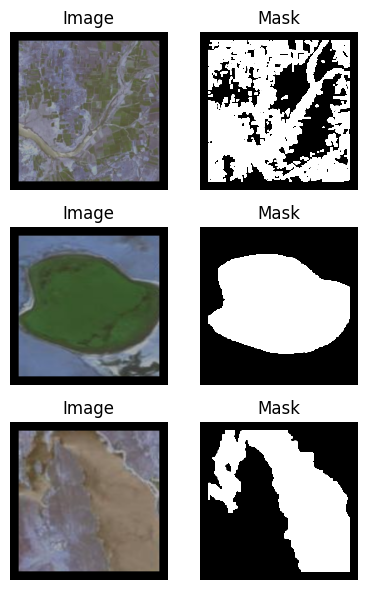

In [10]:
# for i in range(1000, 1011):
#     plt.subplot(1, 2, 1)
#     plt.imshow(images[i])

#     plt.subplot(1, 2, 2)
#     plt.imshow(masks[i])

#     plt.show()
# Generate random indices to select random images
random_indices = np.random.choice(images.shape[0], size=3, replace=False)

# Plot the random images and their masks
fig, axes = plt.subplots(3, 2, figsize=(4, 6))

for i, idx in enumerate(random_indices):
    image = images[idx]
    mask = masks[idx]

    # Plot the image
    axes[i, 0].imshow(image)
    axes[i, 0].axis('off')
    axes[i, 0].set_title('Image')

    # Plot the mask
    axes[i, 1].imshow(mask, cmap='gray', vmin=0, vmax=1)
    axes[i, 1].axis('off')
    axes[i, 1].set_title('Mask')

plt.tight_layout()
plt.show()

In [11]:
# from skimage import morphology

# reshaped_masks = np.reshape(masks, (masks.shape[0] * masks.shape[1], masks.shape[2]))
# footprint = morphology.disk(1)
# filtered_masks = morphology.white_tophat(reshaped_masks, footprint)
# filtered_masks = filtered_masks.reshape(masks.shape)
# print("Masks Matrix shape after filtering:", filtered_masks.shape)

In [39]:
from sklearn.model_selection import train_test_split
img_train, img_test, mask_train, mask_test = train_test_split(images, masks, test_size=0.1, random_state=12)

print("img_train shape:",img_train.shape)
print("mask_train shape:",mask_train.shape)
print("img_test shape:",img_test.shape)
print("mask_test shape:",mask_test.shape)

img_train shape: (495, 256, 256, 3)
mask_train shape: (495, 256, 256, 1)
img_test shape: (56, 256, 256, 3)
mask_test shape: (56, 256, 256, 1)


##### Part 1 - 3

In [13]:
import albumentations as A
from builtins import zip as my_zip

# Convert images and masks to uint8 data type
img_train_uint8 = img_train.astype(np.uint8)
mask_train_uint8 = mask_train.astype(np.uint8)

# Define the augmentation pipeline
augmentation_pipeline = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=50, p=0.5),
    # A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
    A.GridDistortion(p=0.1),
    A.HueSaturationValue(p=0.1),
])

# Apply augmentation to training images and masks
augmented_images = []
augmented_masks = []
for image, mask in my_zip(img_train_uint8, mask_train_uint8):
    augmented = augmentation_pipeline(image=image, mask=mask)
    augmented_images.append(augmented['image'])
    augmented_masks.append(augmented['mask'])

# Convert augmented images and masks back to float64 data type
augmented_images = np.array(augmented_images)
augmented_masks = np.array(augmented_masks)

print("Augmented Images Matrix shape:", augmented_images.shape)
print("Augmented Masks Matrix shape:", augmented_masks.shape)

Augmented Images Matrix shape: (495, 256, 256, 3)
Augmented Masks Matrix shape: (495, 256, 256, 1)


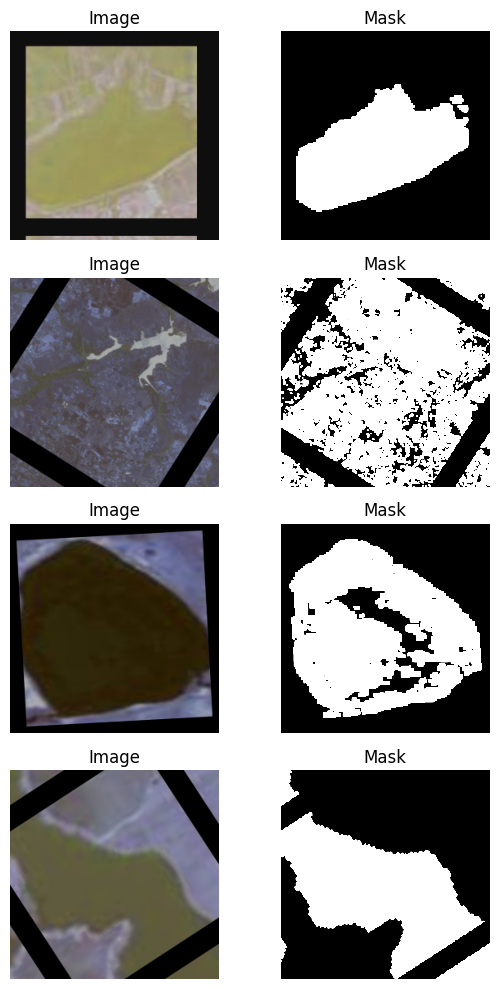

In [44]:
# Generate random indices to select random images
random_indices = np.random.choice(augmented_images.shape[0], size=4, replace=False)

# Plot the random images and their masks
fig, axes = plt.subplots(4, 2, figsize=(6, 10))

for i, idx in enumerate(random_indices):
    image = augmented_images[idx]
    mask = augmented_masks[idx]

    # Plot the image
    axes[i, 0].imshow(image)
    axes[i, 0].axis('off')
    axes[i, 0].set_title('Image')

    # Plot the mask
    axes[i, 1].imshow(mask, cmap='gray', vmin=0, vmax=1)
    axes[i, 1].axis('off')
    axes[i, 1].set_title('Mask')

plt.tight_layout()
plt.show()

In [15]:
# Concatenate augmented images and masks with original training data
img_train_augmented = np.concatenate((img_train, augmented_images))
mask_train_augmented = np.concatenate((mask_train, augmented_masks))

print("Augmented Training Images Matrix shape:", img_train_augmented.shape)
print("Augmented Training Masks Matrix shape:", mask_train_augmented.shape)

Augmented Training Images Matrix shape: (990, 256, 256, 3)
Augmented Training Masks Matrix shape: (990, 256, 256, 1)


In [16]:
mask_train_augmented = np.squeeze(mask_train_augmented, axis=-1)

In [41]:
mask_test = np.squeeze(mask_test, axis = -1)
print(mask_test.shape)

(56, 256, 256)


In [17]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.8 MB/s eta 0:00:00


#### Part 1 - 4 & 1 - 5

In [18]:
# creat my dataset
import numpy as np
from datasets import Dataset
from PIL import Image

img_train_uint8 = img_train_augmented.astype(np.uint8)
mask_train_uint8 = mask_train_augmented.astype(np.uint8)

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img.squeeze()) for img in img_train_uint8],
    "mask": [Image.fromarray(mask.squeeze()) for mask in mask_train_uint8],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

In [43]:
from transformers import SamModel
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

class SAM(Dataset):
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    water_body = self.dataset[idx]
    raw_image = water_body["image"]
    normalized_images = [np.array(image) / 255.0 for image in raw_image]
    real_mask = [np.array(mask).astype(np.uint8) / 255.0 for mask in water_body["mask"]]
    # binary_mask = [np.array(Image.fromarray(mask).convert("1")) for mask in real_mask]
    resulting_mask = np.stack(real_mask, axis=0)
    prompt = bounding_box(resulting_mask)
    data = self.processor(normalized_images, input_boxes=prompt, return_tensors="pt")
    data = {a: b.squeeze(0) for a, b in data.items()}
    data["real_mask"] = real_mask

    return data

In [20]:
pip install monai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.1 MB/s eta 0:00:00


In [21]:
def bounding_box(masks):
    bounding_boxes = []
    for mask in masks:
        height, width = mask.shape
        y_white, x_white = np.where(mask > 0)

        x_min = np.min(x_white)
        x_max = np.max(x_white)
        y_min = np.min(y_white)
        y_max = np.max(y_white)

        x_min = max(0, x_min - np.random.randint(0, 10))
        x_max = min(width, x_max + np.random.randint(0, 10))
        y_min = max(0, y_min - np.random.randint(0, 10))
        y_max = min(height, y_max + np.random.randint(0, 10))

        bounding_boxes.append([[x_min, y_min, x_max, y_max]])

    return bounding_boxes

In [22]:
from torch.utils.data import DataLoader

train_data = SAM(dataset=dataset, processor=processor)
# example = train_data[0:2]
# for k,v in example.items():
#   print(k,v.shape)
train_batched_data = DataLoader(train_data, batch_size=3, shuffle=True)
batch = next(iter(train_batched_data))
for k,v in batch.items():
  print(k,v.shape)
model = SamModel.from_pretrained("facebook/sam-vit-base")

# freeze vision encoder and prompt encoder and fine tune using mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


pixel_values torch.Size([3, 3, 1024, 1024])
original_sizes torch.Size([3, 2])
reshaped_input_sizes torch.Size([3, 2])
input_boxes torch.Size([3, 1, 4])
real_mask torch.Size([3, 256, 256])


config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/375M [00:00<?, ?B/s]

In [23]:
from torch.optim import Adam
import monai
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-4, weight_decay=0)
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [24]:
import torch
from tqdm import tqdm
from statistics import mean
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score

num_epochs = 8
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

losses = []
ious = []  # List to store IoU values

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    epoch_ious = []  # IoU values for the epoch

    for batch in tqdm(train_batched_data):
        # Move the input tensors to the GPU
        batch = {key: value.to(device) for key, value in batch.items()}

        outputs = model(pixel_values=batch["pixel_values"], input_boxes=batch["input_boxes"], multimask_output=False)
        predicted_masks = outputs.pred_masks.squeeze(1)
        loss = seg_loss(predicted_masks, batch["real_mask"].unsqueeze(1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())

        # Calculate IoU for each prediction and target mask in the batch
        for pred_mask, target_mask in zip(predicted_masks, batch["real_mask"]):
            pred_mask = pred_mask.cpu().detach().numpy().astype(bool)
            target_mask = target_mask.cpu().detach(f).numpy().astype(bool)
            iou = jaccard_score(target_mask.flatten(), pred_mask.flatten())
            epoch_ious.append(iou)

    mean_loss = mean(epoch_losses)
    losses.append(mean_loss)
    mean_iou = mean(epoch_ious)
    ious.append(mean_iou)

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean_loss}')
    print(f'Mean IoU: {mean_iou}')


100%|██████████| 330/330 [08:58<00:00,  1.63s/it]


EPOCH: 0
Mean loss: 0.6932275555533919
Mean IoU: 0.4557304921776357


100%|██████████| 330/330 [08:42<00:00,  1.58s/it]


EPOCH: 1
Mean loss: 0.6625483774201759
Mean IoU: 0.4557304921776357


100%|██████████| 330/330 [08:43<00:00,  1.59s/it]


EPOCH: 2
Mean loss: 0.6541142632691903
Mean IoU: 0.4557304921776357


100%|██████████| 330/330 [08:28<00:00,  1.54s/it]


EPOCH: 3
Mean loss: 0.6462202097546856
Mean IoU: 0.4557304921776357


100%|██████████| 330/330 [08:22<00:00,  1.52s/it]


EPOCH: 4
Mean loss: 0.6403340332665289
Mean IoU: 0.45573049819016725


100%|██████████| 330/330 [08:33<00:00,  1.56s/it]


EPOCH: 5
Mean loss: 0.6396234728712006
Mean IoU: 0.4557304921776357


100%|██████████| 330/330 [08:38<00:00,  1.57s/it]


EPOCH: 6
Mean loss: 0.633090736384166
Mean IoU: 0.4557304921776357


100%|██████████| 330/330 [08:39<00:00,  1.57s/it]

EPOCH: 7
Mean loss: 0.6320083490081712
Mean IoU: 0.4557304921776357


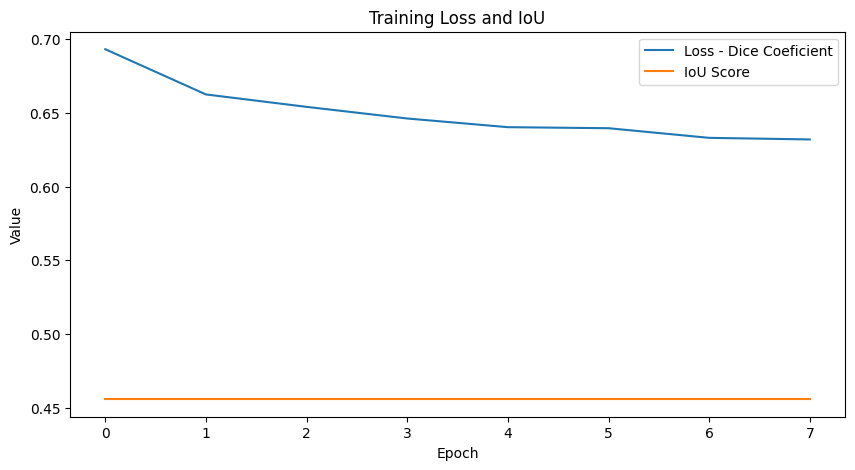

In [27]:
# Plot the loss and IoU on the same plot
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Loss - Dice Coeficient')
plt.plot(ious, label='IoU Score')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Loss and IoU')
plt.legend()
plt.show()

In [36]:
from google.colab import drive
drive.mount('/content/mydrive')
torch.save(model.state_dict(), "/content/mydrive/MyDrive/Colab Notebooks/SAM_Model.pth")

Mounted at /content/mydrive


In [50]:
from transformers import SamModel, SamConfig, SamProcessor

model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

test_model = SamModel(config=model_config)
test_model.load_state_dict(torch.load("/content/mydrive/MyDrive/Colab Notebooks/SAM_Model.pth"))

device = "cuda" if torch.cuda.is_available() else "cpu"
test_model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [51]:
#Get bounding boxes from mask.
def bounding_box_test(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

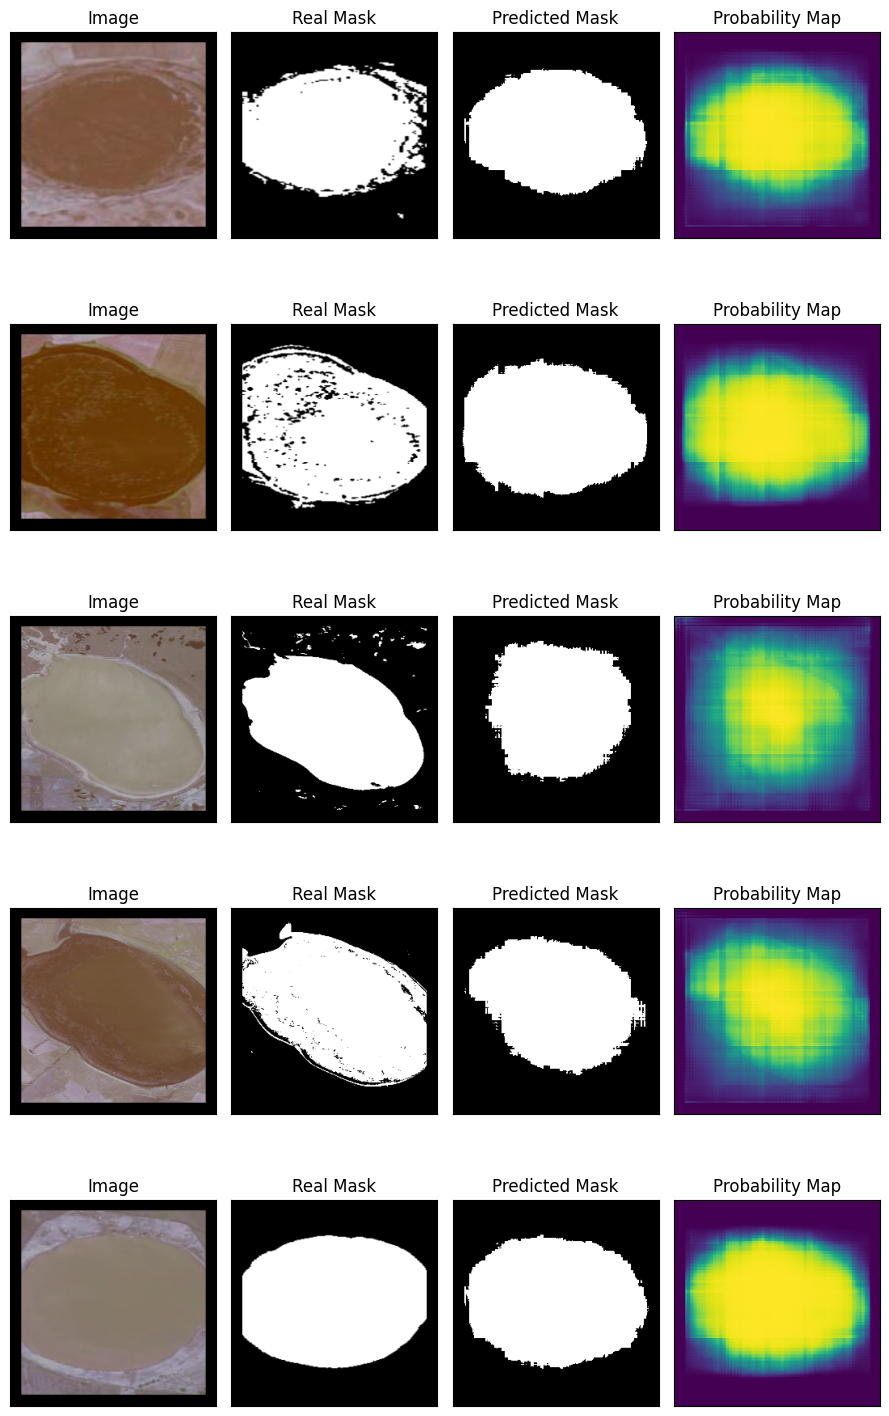

In [58]:
num_images = 5
random_indices = random.sample(range(mask_test.shape[0]), num_images)
fig, axes = plt.subplots(num_images, 4, figsize=(9, num_images*3))

for i, idx in enumerate(random_indices):
    test_image = img_test[idx, :, :, :] / 255.0
    ground_truth_mask = mask_test[idx, :, :] / 255.0
    prompt = bounding_box_test(ground_truth_mask)
    inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    test_model.eval()
    with torch.no_grad():
        outputs = test_model(**inputs, multimask_output=False)
    medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
    medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
    medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

    axes[i, 0].imshow(np.array(test_image), cmap='gray')
    axes[i, 0].set_title("Image")

    axes[i, 1].imshow(ground_truth_mask, cmap='gray')
    axes[i, 1].set_title("Real Mask")

    axes[i, 2].imshow(medsam_seg, cmap='gray')
    axes[i, 2].set_title("Predicted Mask")

    axes[i, 3].imshow(medsam_seg_prob)
    axes[i, 3].set_title("Probability Map")

    for ax in axes[i]:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

plt.tight_layout()
plt.show()